# Pathway relevance analysis of mutation data from drug resistant (DR) *Mtb* strains in transmission clusters

## Introduction

Genome-wide genetic polymorphisms (SNPs) observed in transmission clusters of drug resistance (DR) strains(i.e MDR, Pre-XDR and XDR), but not DR SNPs and neither any SNP in gene Rv2043c (pncA), were used to rank the relevance of a set of pathways using an adaptation of [Verbeke et al.'s network-based approach](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0133503). Although the original approach integrates multiple types of data (gene expression, mutation, methylation and copy number data) together with a-priori knowledge about gene-gene interactions to rank pathways, we focused on uniquely using mutation data (SNPs). Our adaptation constructs a global network where MTb strains, SNPs and genes are represented as nodes. Relations between nodes, represented as undirected edges, include: i) the presence of a SNP in a particular strain, ii) the  assignment of a SNP to a particular gene (intergenic SNPs were assigned to a gene if they were located before the start codon) and iii) the physical or functional interaction between genes. The last set of relations were derived from KEGG pathways.

As in Verbeke et al.'s approach, to measure the  degree of relatedness between each pair of nodes, we derived a global similarity matrix by applaying the Laplacian Exponential Diffusion (LED) kernel on the graph followed by normalization. Since kernel on graph nodes assume a fully connected network, we applied the kernel on the largest connected component of our global network if it was not fully connected. Our fully connected component was composed of 917 MTb strain nodes, 1119 SNP nodes and 1372 gene nodes.

The LED kernel is influenced by a diffusion parameter (α) that was set to 0.1, however stable results were shown between 0.001 and 0.1. Given an MTb strain and a pathway composed of a set of genes, the average of the similarities between the MTb strain and each gene in the pathway corresponds to the pathway importance score for that MTb strain. The pathway importance score for a set of MTb strains is obtained by averaging their importance scores. To get the probability of obtaining by chance an importance score at least as extreme as the one obtained, a random score distribution is obtained for the pathway. This random distribution is obtained by repeatedly calculating the pathway importance score from sets of genes randomly sampled from the similarity matrix. The size of the randomly sampled gene sets is equal to the size of the pathway gene set. Thus the pathway importance score is ultimately converted to a p-value. Pathways with only one gene were ignored.

The adapted method is implemented as a Python package available at https://git.scicore.unibas.ch/TBRU/pathways.


## 0. Set-up

In [1]:
% cd ../
% load_ext autoreload

/home/mticlla/Documents/Git_repositories/pathways


In [2]:
import os as os
from itertools import chain
from BCBio import GFF
import pprint
from BCBio.GFF import GFFExaminer
from pathways.graph import create_global_graph
from pathways.kernel import get_kernel
from pathways.pathways_relevance import score_pathways
import numpy as np
import re
import pandas as pd
import igraph
from igraph import Graph
import matplotlib.pyplot as plt

%autoreload 2

/home/mticlla/.pyenv/versions/3.5.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mticlla/.pyenv/versions/3.5.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mticlla/.pyenv/versions/3.5.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mticlla/.pyenv/versions/3.5.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mticlla/.pyenv/versions/3.5.0/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  retu

## 1. Defining functions

In [3]:
#------------------------------------------------------------------------------
# Functions
#------------------------------------------------------------------------------

# Parses a gff3 file and returns a dictionary with genes as elements
# Tha value for each gene is a dictionary with keys that include:
# ID, name, start, end, strand
def get_genes_from_gff(gff_file, gff_id="MTB_anc",
                       gff_source="RefSeq",
                       gff_type="gene"):
    limit_info = dict(
        gff_id=[gff_id],
        gff_source=[gff_source],
        gff_type=[gff_type])

    results = dict()
    in_handle = open(gff_file)
    for rec in GFF.parse(in_handle, limit_info=limit_info):
        for feature in rec.features:
            location = feature.location
            start = int(location.start)
            end = int(location.end)
            strand = location.strand

            qualifiers = dict()
            for qualifier in feature.qualifiers:
                qualifiers[qualifier] = feature.qualifiers[qualifier][0]

            qualifiers["start"] = start
            qualifiers["end"] = end
            qualifiers["strand"] = strand
            results[qualifiers["locus_tag"]] = qualifiers
    in_handle.close()
    return results

## 2. Input files

In [4]:
# Gene anootations file in gff3 format
genes_annotations_file = './examples/data/genes.gff'

# Gene-Gene interactions file
net_file = './examples/data/Reconstructed_network.txt'

# File listing snp/indel-gene iteractions
snp_gene_file = './examples/data/georgia/201812_SNPs_to_clusters'

# File listing SNPs-in-Samples
snp_sample_file = './examples/data/georgia/201812_snps_indels_to_samples'

# File listing samples in transmission clusters
samples_in_transmission_cl_file = './examples/data/georgia/201812_Gnr_to_Clusters'

# File listing samples and their metadata
samples_metadata_file = './examples/data/georgia/201808_metadata_MDR'

## 3. Create needed tables

In [5]:
#------------------------------------------------------------------------------
# Gene annotations
#------------------------------------------------------------------------------
# Examine the structure of the GFF file
examiner = GFFExaminer()
in_handle = open(genes_annotations_file)
pprint.pprint(examiner.available_limits(in_handle))
in_handle.close()

MTB_genes = pd.DataFrame.from_dict(get_genes_from_gff(gff_file=genes_annotations_file),
                                   orient='index')

{'gff_id': {('MTB_anc',): 8407},
 'gff_source': {('RefSeq',): 8407},
 'gff_source_type': {('RefSeq', 'CDS'): 3906,
                     ('RefSeq', 'exon'): 70,
                     ('RefSeq', 'gene'): 4008,
                     ('RefSeq', 'mobile_genetic_element'): 56,
                     ('RefSeq', 'ncRNA'): 20,
                     ('RefSeq', 'rRNA'): 3,
                     ('RefSeq', 'region'): 1,
                     ('RefSeq', 'repeat_region'): 262,
                     ('RefSeq', 'sequence_feature'): 34,
                     ('RefSeq', 'tRNA'): 45,
                     ('RefSeq', 'transcript'): 2},
 'gff_type': {('CDS',): 3906,
              ('exon',): 70,
              ('gene',): 4008,
              ('mobile_genetic_element',): 56,
              ('ncRNA',): 20,
              ('rRNA',): 3,
              ('region',): 1,
              ('repeat_region',): 262,
              ('sequence_feature',): 34,
              ('tRNA',): 45,
              ('transcript',): 2}}


In [6]:
#------------------------------------------------------------------------------
# snp - gene interactions
#------------------------------------------------------------------------------
# Load snp_gene_file
snp_gene = pd.read_csv(snp_gene_file, sep='\t', header=0, index_col=False)
print('Number of SNPs before filtering: {}'.format(snp_gene.shape[0]))

# Assign gene to SNP
# assignment is based on the sense of the strand where the genes are lying
snp_gene['Gene_ID'] = np.nan
for index,row in snp_gene.iterrows():
    if '-' in row['Gene']:
        gene1 = row['Gene'].split('-')[0].split('_')[-1]
        gene2 = row['Gene'].split('-')[1].split('_')[-1]
        
        if MTB_genes.loc[gene1,'strand']+MTB_genes.loc[gene2,'strand'] == 2:
            snp_gene.loc[index,'Gene_ID'] = gene1
        elif MTB_genes.loc[gene1,'strand']+MTB_genes.loc[gene2,'strand'] == -2:
            snp_gene.loc[index,'Gene_ID'] = gene2
        elif MTB_genes.loc[gene1,'strand'] == 1:
            snp_gene.loc[index,'Gene_ID'] = '{}-{}'.format(gene1,gene2)
        else:
            # Here we have intergenic SNPs lying between a gene in the antisense strand and 
            # a gene in the sense strand
            snp_gene.loc[index,'Gene_ID'] = np.nan
    elif '-' not in row['Gene']:
        gene = row['Gene'].split('_')[1]
        snp_gene.loc[index,'Gene_ID'] = gene
        
# Filter SNPs list
# - Keep only SNPs assigned to a gene, and
# - not conferring drug resistance
# - Remove all SNPs in gene 'Rv2043c'
snp_to_keep_indices = snp_gene.index[~snp_gene.Gene_ID.isnull().values & (snp_gene.DR_mut == 0)].values
snp_gene_noDR_wGenes = snp_gene.loc[snp_to_keep_indices,:]
snp_gene_noDR_wGenes = snp_gene_noDR_wGenes.loc[~(snp_gene_noDR_wGenes.Gene_ID == 'Rv2043c'),]
print('Number of SNPs after filtering: {}'.format(snp_gene_noDR_wGenes.shape[0]))

Number of SNPs before filtering: 1111
Number of SNPs after filtering: 997


In [7]:
# snp by gene table (zeroes and ones)
# ------------------------------------------------
genesIDs_with_snps = list(set(chain.from_iterable(gene.split('-') if '-' in gene else [gene] \
                                               for gene in snp_gene_noDR_wGenes.Gene_ID.values)))

data_zeroes = np.zeros((snp_gene_noDR_wGenes.shape[0], len(genesIDs_with_snps)))
snps_by_genes_nodr_table = pd.DataFrame(data=data_zeroes, 
                                        index=snp_gene_noDR_wGenes.SNP_ID, 
                                        columns=genesIDs_with_snps, 
                                        dtype=np.uint8)

def fill_snps_by_genes_nodr_table(df_row):
    if '-' in df_row.Gene_ID:
        genes = df_row.Gene_ID.split('-')
        snps_by_genes_nodr_table.loc[df_row.SNP_ID, genes] = 1
    else:
        snps_by_genes_nodr_table.loc[df_row.SNP_ID, df_row.Gene_ID] = 1
    pass
        
temp = snp_gene_noDR_wGenes.apply(fill_snps_by_genes_nodr_table, axis=1)
print('Dimensions of SNP by gene table after filtering: \n' +\
      '{} SNPs amd {} Genes'.format(snps_by_genes_nodr_table.shape[0], snps_by_genes_nodr_table.shape[1]))
print(snps_by_genes_nodr_table.iloc[0:5,0:5])

Dimensions of SNP by gene table after filtering: 
997 SNPs amd 828 Genes
         Rv2385  Rv2606c  Rv2699c  Rv3121  Rv0825c
SNP_ID                                            
SNP_000       0        0        0       0        0
SNP_001       0        0        0       0        0
SNP_002       0        0        0       0        0
SNP_003       0        0        0       0        0
SNP_004       0        0        0       0        0


In [8]:
#------------------------------------------------------------------------------
# snp - sample interactions
#------------------------------------------------------------------------------
snp_sample = pd.read_csv(snp_sample_file, sep='\t', header=0, index_col=False)

# Group Sample_ID(Gnumber) by 'SNP_ID
snp_sample_grouped = snp_sample.loc[:,['Sample_ID','SNP_ID']].groupby(['SNP_ID'])

# Create and fill the SNP by sample table
samples_ids = list(set(snp_sample.Sample_ID.sort_values()))
snps_ids = snp_gene_noDR_wGenes.SNP_ID.values
table_zeros = np.zeros((len(snps_ids),len(samples_ids)))

snps_samples_table = pd.DataFrame(data=table_zeros, index=snps_ids, columns=samples_ids, dtype=np.int8)
# Function created to take each SNP (row) of snps_samples_table, and
# change to 1 values for Samples_ids (columns) with this SNP
def add_samples_to_snp(row):
    new_row = row
    new_row[snp_sample_grouped.get_group(row.name).Sample_ID.values] = 1
    return new_row
snps_samples_table = snps_samples_table.apply(add_samples_to_snp, axis=1)

print('Dimensions of SNP by Sample table: \n' + \
      '{} SNPs and {} samples'.format(snps_samples_table.shape[0],snps_samples_table.shape[1]))
print(snps_samples_table.iloc[0:5,0:5])

Dimensions of SNP by Sample table: 
997 SNPs and 659 samples
         G07320  G03077  G03553  G02911  G02963
SNP_000       0       0       0       0       0
SNP_001       0       0       0       0       0
SNP_002       0       0       0       0       0
SNP_003       0       0       0       0       0
SNP_004       0       1       0       0       0


In [9]:
# gene - gene interactions table
# ------------------------------------------------
gene_a = []
gene_b = []
net = open(net_file, 'r')
for line in net:
    genes = re.split(' |:', line.rstrip())
    gene_a.append(genes[1])
    gene_b.append(genes[3])
net.close()

net = pd.DataFrame({'A': gene_a,
                    'B': gene_b})
print('Gene - Gene interactions: {}'.format(net.shape[0]))
print('Number of unique genes: {}'.format(len(set(net.A) | set(net.B))))
print(net.head())

Gene - Gene interactions: 4676
Number of unique genes: 645
        A        B
0  Rv1381   Rv1380
1  Rv1381   Rv2139
2  Rv3526  Rv1257c
3  Rv3526  Rv3570c
4  Rv3526  Rv3545c


## 4. Compute global graph and kernel

### 4.1 Create global graph

In [10]:
# Create global graph
my_global_graph = create_global_graph(snp_sample=snps_samples_table, 
                                      snp_gene=snps_by_genes_nodr_table, 
                                      gene_gene=net)
# how many samples were kept in the graph
print('Nr. of samples in my graph: {}'.format(len(my_global_graph.samples_indices)))
print('Nr. of SNPs in my graph: {}'.format(len(my_global_graph.snps_indices)))
print('Nr. of genes in my graph: {}'.format(len(my_global_graph.genes_indices)))

Nr. of samples in my graph: 659
Nr. of SNPs in my graph: 997
Nr. of genes in my graph: 1312


In [11]:
# my_global_graph is an instance of class GlobalGraph which is also a 
# subclass of Graph from the igraph package
type(my_global_graph)

pathways.graph.GlobalGraph

### 4.2 Compute graph kernel

In [12]:
# Compute graph kernels

# Non-transformed kernel
# ----------------------------
my_global_graph_kernel = get_kernel(my_global_graph, method='led', alpha=0.1)

# Normalized graph kernel matrix
# ------------------------------
# In a normalized kernel matrix, its elements corresponds to the inner products
# of the normalized node vectors (xi/||xi||).
# The advantage of normalizing the kernel matrix is that we control
# the effect of the length of the node vectors when computing the similarity measure.
# We avoid two node vectors being more similar just because they have a similar length.
my_global_graph_kernel_n = my_global_graph_kernel.normalize(inplace=False)

In [13]:
# my_global_graph_kernel is an instance of class GraphKernel
# check 'pathways' documentation for method of this class 
type(my_global_graph_kernel)

pathways.kernel.GraphKernel

## 5. Rank pathways

### 5.1 Mtb Pathways

In [14]:
# gene_pathways table
# ----------------------------
pathway_names_file = './test_data/mtu_pathways.txt'
pathway_genes_file = './test_data/mtu_pathways_and_genes.txt'

pathway_table = pd.read_csv(pathway_genes_file, sep='\t', header=0, index_col=0)
print('Dimensions of table before filtering: \n' + \
      'Nr of genes: {} \n'.format(pathway_table.shape[0]) + \
      'Nr of pathways: {}'.format(pathway_table.shape[1]))
print(pathway_table.iloc[0:4,0:4])

# Exclude pathways with only one gene
pathway_table = pathway_table.loc[:,pathway_table.sum(axis=0) != 1]
print('Dimensions of table after filtering: \n' + \
      'Nr of genes: {} \n'.format(pathway_table.shape[0]) + \
      'Nr of pathways: {}'.format(pathway_table.shape[1]))

pathway_names = dict()
file_in = open(pathway_names_file, 'r')
for line in file_in:
    pathway = re.split('\t', line.rstrip())
    pathway_names[pathway[0]] = pathway[1]
file_in.close()

# Create dictionary with genes for pathways
pathways_genes = dict()
for pathway in pathway_table.columns.values:
    pathways_genes[pathway] = pathway_table.index.values[pathway_table.loc[:,pathway] == 1]

Dimensions of table before filtering: 
Nr of genes: 996 
Nr of pathways: 121
          path:mtu00010  path:mtu00020  path:mtu00030  path:mtu00040
RVnc0006              0              0              0              0
Rv0001                0              0              0              0
Rv0002                0              0              0              0
Rv0003                0              0              0              0
Dimensions of table after filtering: 
Nr of genes: 996 
Nr of pathways: 117


### 5.2 Get scores for pathways

**5.2.1 For MDR samples in transmission clusters**

In [15]:
# Get ranked pathways for all drug resistant samples in transmission clusters
# drug resistant samples in transmission clusters
samples_in_tr_cluster = pd.read_csv(samples_in_transmission_cl_file, sep='\t', header=0)
print('Nr. MDR+ samples in transmission clusters: {}'.format(samples_in_tr_cluster.shape[0]))
print('Nr. of transmission clusters: {}'.format(len(samples_in_tr_cluster.Cluster_ID.unique())))
print(samples_in_tr_cluster.iloc[0:5,])

# using the normalized kernel
pathways_scores_inTrclus_Kn = score_pathways(my_global_graph, 
                                             my_global_graph_kernel_n, 
                                             pathways=pathways_genes, 
                                             names=pathway_names, 
                                             samples=samples_in_tr_cluster.Gnr.values, 
                                             threshold=2, permutations=999)

Nr. MDR+ samples in transmission clusters: 281
Nr. of transmission clusters: 42
      Gnr  Cluster_ID
0  G03596           1
1  G03439           1
2  G03598           1
3  G03557           1
4  G03580           1
_
_
_
_
_
_
_
_
_
Cationic antimicrobial peptide (CAMP) resistance : no genes found in kernel matrix
_
_
Non-homologous end-joining : no genes found in kernel matrix


**5.2.2 For non-clustered MDR+ strains**

In [16]:
# Get ranked pathways for all drug resistant samples NOT in transmission clusters
samples_NOT_in_tr_cluster = list(set(my_global_graph.samples_names)-set(samples_in_tr_cluster.Gnr.values))

print('Nr. MDR+ samples NOT in transmission clusters: {}'.format(len(samples_NOT_in_tr_cluster)))

# using the normalized kernel
pathways_scores_NOT_inTrclus_Kn = score_pathways(my_global_graph, 
                                             my_global_graph_kernel_n, 
                                             pathways=pathways_genes, 
                                             names=pathway_names, 
                                             samples=samples_NOT_in_tr_cluster, 
                                             threshold=2, permutations=999)

Nr. MDR+ samples NOT in transmission clusters: 378
_
_
_
_
_
_
_
_
_
Cationic antimicrobial peptide (CAMP) resistance : no genes found in kernel matrix
_
_
Non-homologous end-joining : no genes found in kernel matrix


**5.2.3 For each DR class**

In [17]:
# Samples metadata
samples_metadata = pd.read_csv(samples_metadata_file, sep='\t', header=0, index_col=0)
# MDR+ groups
print('MDR groups:')
print(samples_metadata.DR_class.value_counts())
print('Total: {}'.format(samples_metadata.DR_class.value_counts().sum()))

MDR groups:
PreXDR_INJ       272
MDR_remaining    257
XDR               98
PreXDR_FLQ        32
Name: DR_class, dtype: int64
Total: 659


In [18]:
#
samples_MDR = samples_metadata.index[samples_metadata.DR_class == 'MDR_remaining'].values
samples_in_tr_cluster_Gnr_MDR = set(samples_in_tr_cluster.Gnr) & set(samples_MDR)

samples_PreXDR_INJ = samples_metadata.index[samples_metadata.DR_class == 'PreXDR_INJ'].values
samples_in_tr_cluster_PreXDR_INJ = set(samples_in_tr_cluster.Gnr) & set(samples_PreXDR_INJ)

samples_PreXDR_FLQ = samples_metadata.index[samples_metadata.DR_class == 'PreXDR_FLQ'].values
samples_in_tr_cluster_PreXDR_FLQ = set(samples_in_tr_cluster.Gnr) & set(samples_PreXDR_FLQ)

samples_XDR = samples_metadata.index[samples_metadata.DR_class == 'XDR'].values
samples_in_tr_cluster_samples_XDR = set(samples_in_tr_cluster.Gnr) & set(samples_XDR)

In [19]:
# Get ranked pathways for all drug resistance classes

# For MDR samples
pathways_scores_MDR_Kn = score_pathways(my_global_graph, my_global_graph_kernel_n,
                                        pathways=pathways_genes, names=pathway_names,
                                        samples=samples_in_tr_cluster_Gnr_MDR, 
                                        threshold=2, permutations=999)

_
_
_
_
_
_
_
_
_
Cationic antimicrobial peptide (CAMP) resistance : no genes found in kernel matrix
_
_
Non-homologous end-joining : no genes found in kernel matrix


In [20]:
# For PreXDR_INJ
pathways_scores_PreXDR_INJ_Kn = score_pathways(my_global_graph, my_global_graph_kernel_n,
                                        pathways=pathways_genes, names=pathway_names,
                                        samples=samples_in_tr_cluster_PreXDR_INJ, 
                                        threshold=2, permutations=999)

_
_
_
_
_
_
_
_
_
Cationic antimicrobial peptide (CAMP) resistance : no genes found in kernel matrix
_
_
Non-homologous end-joining : no genes found in kernel matrix


In [21]:
# For PreXDR_FLQ
pathways_scores_PreXDR_FLQ_Kn = score_pathways(my_global_graph, my_global_graph_kernel_n,
                                        pathways=pathways_genes, names=pathway_names,
                                        samples=samples_in_tr_cluster_PreXDR_FLQ, 
                                        threshold=2, permutations=999)

_
_
_
_
_
_
_
_
_
Cationic antimicrobial peptide (CAMP) resistance : no genes found in kernel matrix
_
_
Non-homologous end-joining : no genes found in kernel matrix


In [22]:
# For XDR
pathways_scores_XDR_Kn = score_pathways(my_global_graph, my_global_graph_kernel_n,
                                        pathways=pathways_genes, names=pathway_names,
                                        samples=samples_in_tr_cluster_samples_XDR, 
                                        threshold=2, permutations=999)

_
_
_
_
_
_
_
_
_
Cationic antimicrobial peptide (CAMP) resistance : no genes found in kernel matrix
_
_
Non-homologous end-joining : no genes found in kernel matrix


## 6. Visualize top ranked pathways

### 6.1 For Samples in transmission clusters

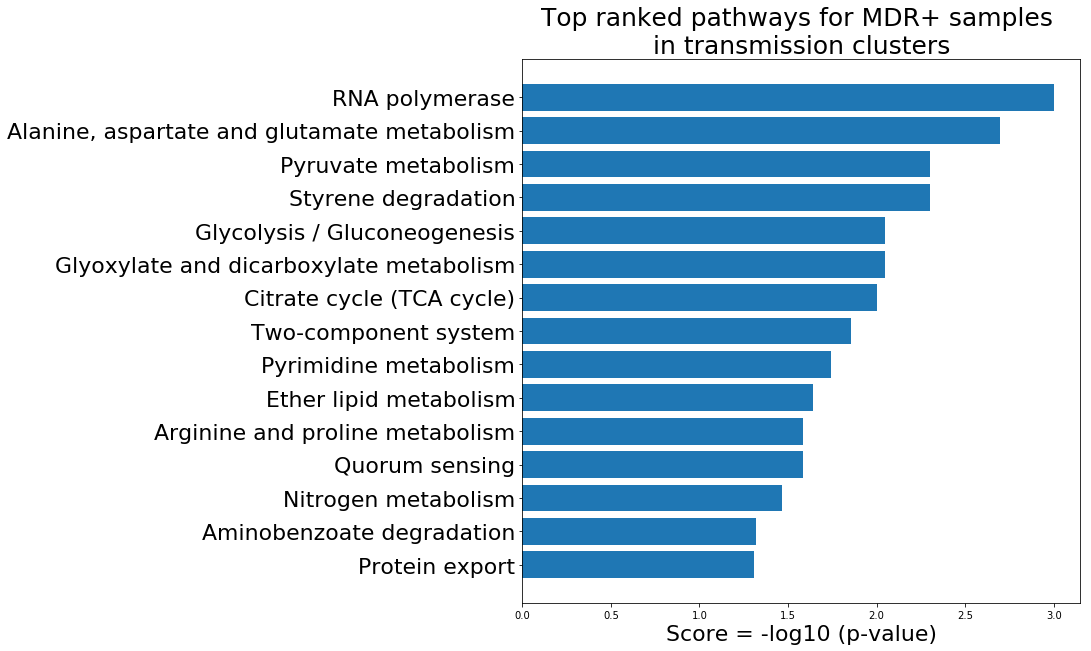

In [23]:
fig1, ax1= plt.subplots()
fig1.set_size_inches(10,10)

pathways_scores_inTrclus_Kn.plot_pathways(threshold=0.05, ax=ax1)
ax1.set_title('Top ranked pathways for MDR+ samples \nin transmission clusters', fontsize=25)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
plt.xlabel('Score = -log10 (p-value)', fontsize=22)
fig1.tight_layout
plt.show()
fig1.savefig('./examples/figures/georgia/pathways_ranked_MDRplus_trClusters.pdf', bbox_inches='tight', format='pdf', dpi=1)

### 6.2 For Samples NOT in transmission clusters

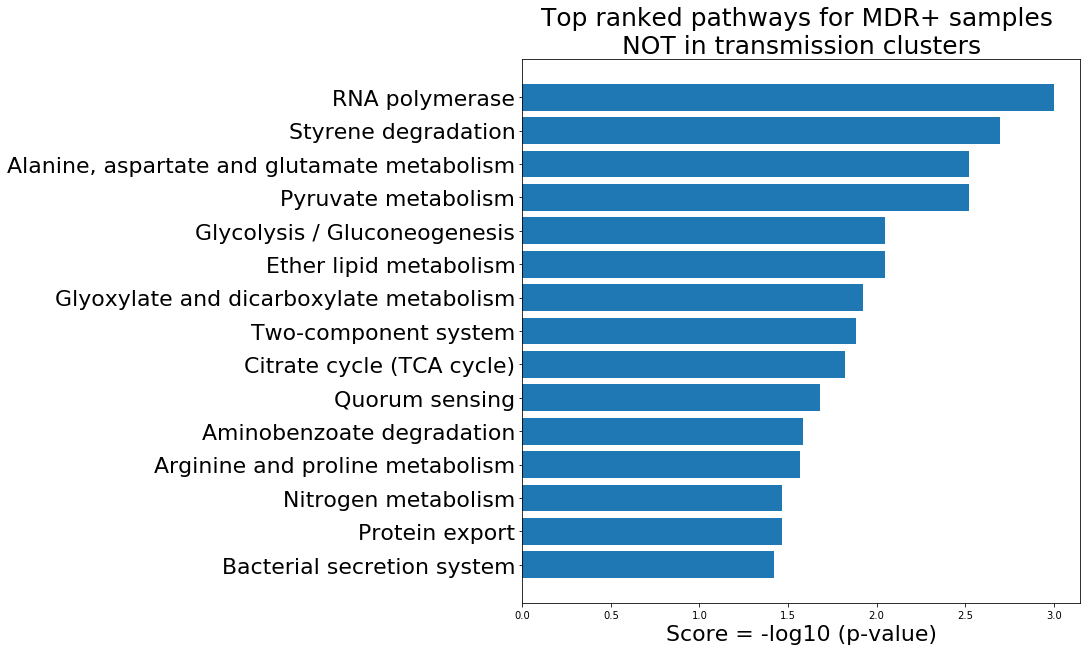

In [24]:
fig1_1, ax1_1= plt.subplots()
fig1_1.set_size_inches(10,10)

pathways_scores_NOT_inTrclus_Kn.plot_pathways(threshold=0.05, ax=ax1_1)
ax1_1.set_title('Top ranked pathways for MDR+ samples \nNOT in transmission clusters', fontsize=25)
for tick in ax1_1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
plt.xlabel('Score = -log10 (p-value)', fontsize=22)
fig1_1.tight_layout
plt.show()
fig1_1.savefig('./examples/figures/georgia/pathways_ranked_MDRplus_NOT_in_trClusters.pdf', bbox_inches='tight', format='pdf', dpi=1)

### 6.3 clustered vs unclustered MDR+ strains

In [25]:
# Pathways ranked as relevant for clustered MDR strains
pathways_sig_clustered = pathways_scores_inTrclus_Kn.significant_pathways(threshold=0.05)
pathways_sig_clustered_names = [pathway_names[pathway]for pathway in pathways_sig_clustered]

# P_scores of relevant pathways for clustered MDR strains
# in clustered strains
pathways_sig_clustered_pscores = np.abs(-1*np.log10([pathways_scores_inTrclus_Kn.p_scores[pathway] for pathway in pathways_sig_clustered]))
# and not clustered strains
pathways_sig_not_clustered_pscores = -1*np.log10([pathways_scores_NOT_inTrclus_Kn.p_scores[pathway] for pathway in pathways_sig_clustered])

# Ratio of p-scores: clustered over not clustered
pathways_sig_pscores_ratio = pathways_sig_clustered_pscores/pathways_sig_not_clustered_pscores

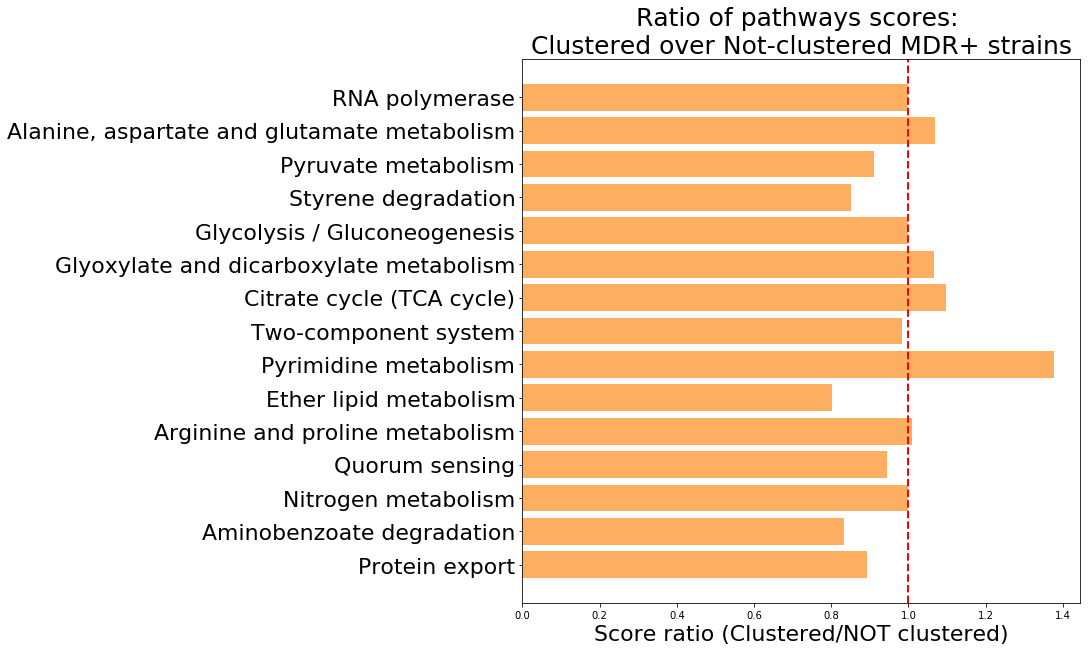

In [26]:
fig1_2, ax1_2 = plt.subplots()
fig1_2.set_size_inches(10,10)
ax1_2.barh(np.arange(len(pathways_sig_clustered_names)), 
           pathways_sig_pscores_ratio, 
           align='center', color='#fdae61')
ax1_2.set_yticks(np.arange(len(pathways_sig_clustered_names)))
ax1_2.set_yticklabels(pathways_sig_clustered_names)
for tick in ax1_2.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
ax1_2.invert_yaxis()
ax1_2.axvline(x=1, linewidth=2, linestyle='--', color='r')
ax1_2.set_xlabel('Score ratio (Clustered/NOT clustered)', fontsize=22)
ax1_2.set_title('Ratio of pathways scores: \nClustered over Not-clustered MDR+ strains', 
                fontsize=25)
plt.show()
fig1_2.savefig('./examples/figures/georgia/pathways_ranked_MDRplus_clustered_vs_NOTclustered.pdf', bbox_inches='tight', format='pdf', dpi=1)

### 6.4 For samples per DR class

In [36]:
fig2, axArray = plt.subplots(2,2, sharex='col')
fig2.set_size_inches(80,40)

pathways_scores_MDR_Kn.plot_pathways(threshold=0.05, ax=axArray[0,0])
axArray[0,0].set_title('MDR', fontsize=25)
for tick in axArray[0,0].yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
plt.xlabel('-log10 (p-value)', fontsize=22)

pathways_scores_PreXDR_INJ_Kn.plot_pathways(threshold=0.05, ax=axArray[0,1])
axArray[0,1].set_title('PRE-XDR (Injectables)', fontsize=25)
for tick in axArray[0,1].yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
plt.xlabel('-log10 (p-value)', fontsize=22)

pathways_scores_PreXDR_FLQ_Kn.plot_pathways(threshold=0.05, ax=axArray[1,0])
axArray[1,0].set_title('PRE-XDR (FQ)', fontsize=25)
for tick in axArray[1,0].yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
plt.xlabel('-log10 (p-value)', fontsize=22)

pathways_scores_XDR_Kn.plot_pathways(threshold=0.05, ax=axArray[1,1])
axArray[1,1].set_title('XDR', fontsize=25)
for tick in axArray[1,1].yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
plt.xlabel('-log10 (p-value)', fontsize=22)

fig2.tight_layout
plt.show()
fig2.savefig('./examples/figures/georgia/pathways_ranked_DRgroups.pdf', bbox_inches='tight', format='pdf', dpi=1)

## 7. Visualize scores of genes in top ranked pathways

### 7.1 For Samples in transmission clusters

**All genes in top ranked pathways**

In [37]:
fig3, ax2= plt.subplots()
fig3.set_size_inches(35,60)

pathways_scores_inTrclus_Kn.plot_genes_in_significant_pathways(threshold=0.05, ax=ax2)
ax2.set_title('MDR+ samples in transmission clusters', y=1.05)

fig3.tight_layout
plt.show()
fig3.savefig('./examples/figures/georgia/genes_ranked_MDRplus_trClusters.pdf', bbox_inches='tight', format='pdf')

# Gene score: averaged sample-gene similarity values

**Genes covering some percentage of the pathway raw score**

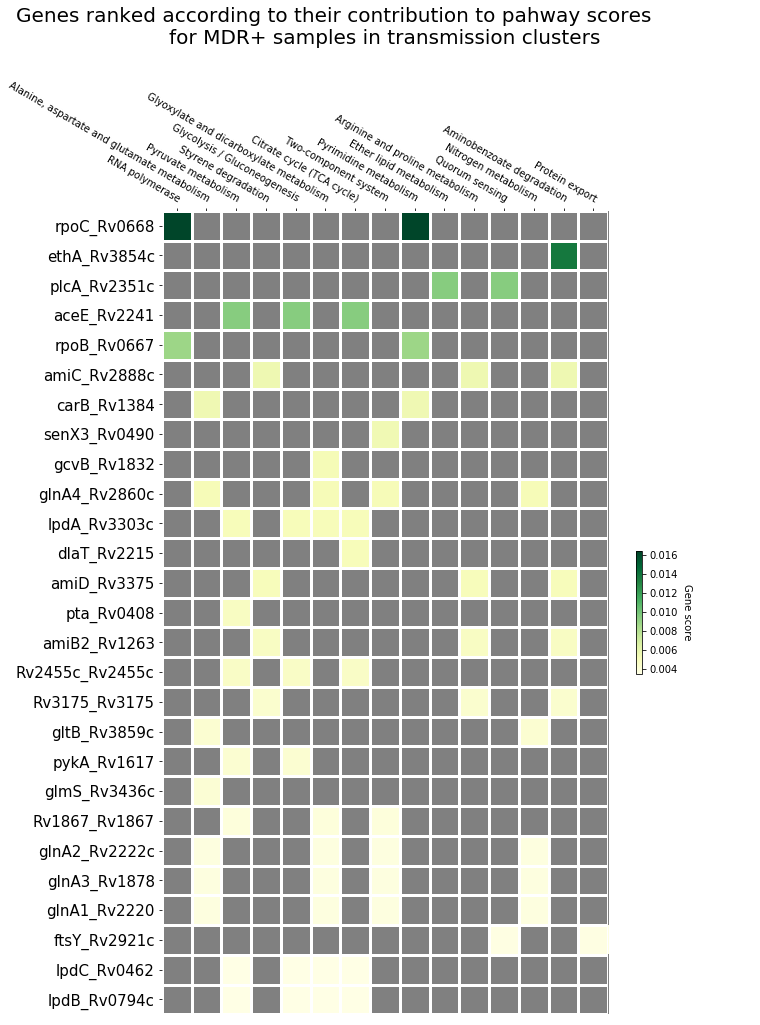

In [38]:
fig4, ax3= plt.subplots()
fig4.set_size_inches(10,15)

# Plot the top ranked genes, including only those covering 60% of the pathway raw score
pathways_scores_inTrclus_Kn.plot_genes_in_significant_pathways(threshold=0.05, ax=ax3, coverage=40)
ax3.set_title('Genes ranked according to their contribution to pahway scores \
               \nfor MDR+ samples in transmission clusters', y=1.20, fontsize=20)
# Change gene IDs for names
y_labels = list(MTB_genes.loc[list(item.get_text() for item in ax3.get_yticklabels()), 'Name'])
ax3.set_yticklabels(y_labels)

for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
fig4.tight_layout
plt.show()
fig4.savefig('./examples/figures/georgia/genes_ranked_cov40_MDRplus_trClusters.pdf', 
             bbox_inches='tight', format='pdf')

### 7.2 For Samples NOT in transmission clusters

In [39]:
fig4_1, ax4= plt.subplots()
fig4_1.set_size_inches(10,14)

# Plot the top ranked genes, including only those covering 60% of the pathway raw score
pathways_scores_NOT_inTrclus_Kn.plot_genes_in_significant_pathways(threshold=0.05, ax=ax4, coverage=60)
ax4.set_title('MDR+ samples non-clustered', y=1.20)

fig4_1.tight_layout
plt.show()
fig4_1.savefig('./examples/figures/georgia/genes_ranked_cov60_MDRplus_NOT_in_trClusters.pdf', 
               bbox_inches='tight', format='pdf')

### 7.3 For DR groups

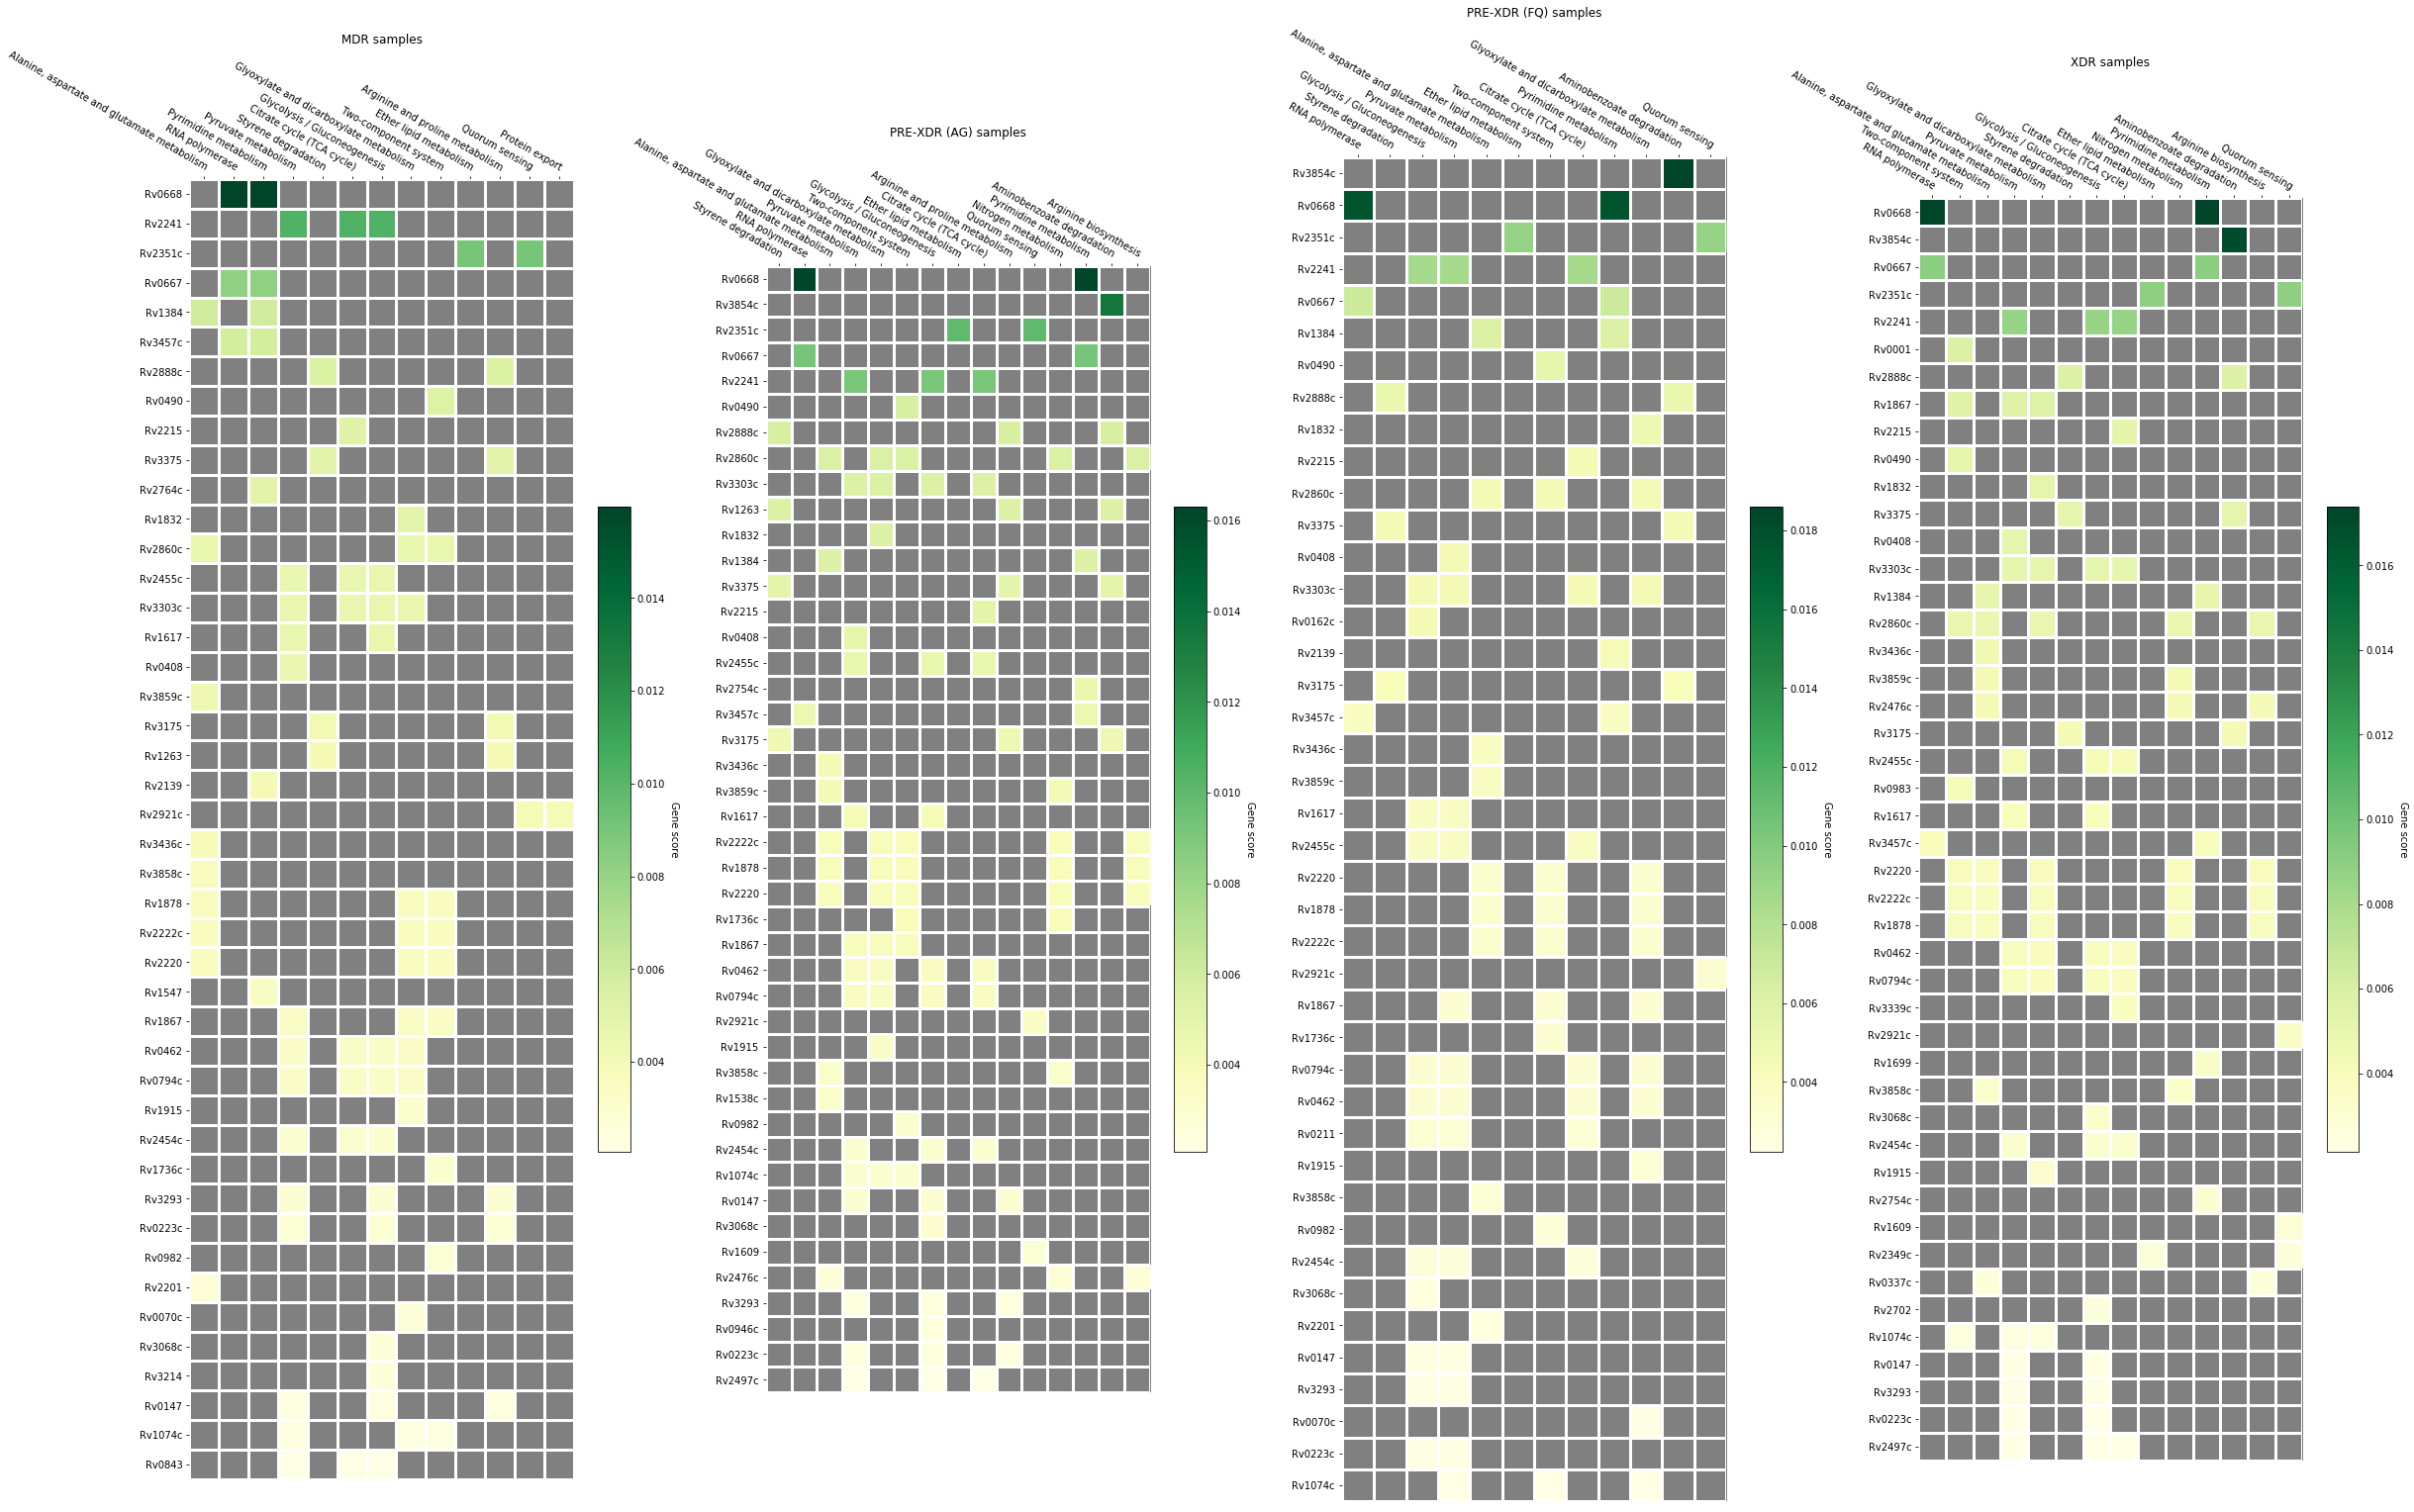

In [40]:
fig5, axArray2 =  plt.subplots(1,4, sharex='col')
fig5.set_size_inches(40,80)

pathways_scores_MDR_Kn.plot_genes_in_significant_pathways(threshold=0.05, ax=axArray2[0], coverage=60)
axArray2[0].set_title('MDR samples', y=1.10)

pathways_scores_PreXDR_INJ_Kn.plot_genes_in_significant_pathways(threshold=0.05, ax=axArray2[1], coverage=60)
axArray2[1].set_title('PRE-XDR (AG) samples', y=1.11)

pathways_scores_PreXDR_FLQ_Kn.plot_genes_in_significant_pathways(threshold=0.05, ax=axArray2[2], coverage=60)
axArray2[2].set_title('PRE-XDR (FQ) samples', y=1.10)

pathways_scores_XDR_Kn.plot_genes_in_significant_pathways(threshold=0.05, ax=axArray2[3], coverage=60)
axArray2[3].set_title('XDR samples', y=1.10)

fig5.tight_layout
plt.show()
fig5.savefig('./examples/figures/georgia/genes_ranked_DRgroups.pdf', bbox_inches='tight', format='pdf')

## 8. Extract top ranked genes and their SNPs from global network

### 8.1 For Samples in transmission clusters

In [41]:
# Top ranked genes in significant pathways covering 60% of the pathway raw score
significant_pathways = pathways_scores_inTrclus_Kn.significant_pathways(threshold=0.05)
genes_names_to_extract = list()
for pathway in significant_pathways:
    genes_scores = pathways_scores_inTrclus_Kn.genes_in_pathway(pathway_name=pathway, coverage=60)
    genes_names = [gene for score, gene in genes_scores]
    genes_names_to_extract.extend(genes_names)
genes_names_to_extract = list(set(genes_names_to_extract))

print(genes_names_to_extract)

['Rv2222c', 'Rv2220', 'Rv3175', 'Rv0001', 'Rv2241', 'Rv2921c', 'Rv3854c', 'Rv3859c', 'Rv1263', 'Rv3068c', 'Rv2754c', 'Rv2351c', 'Rv0490', 'Rv1617', 'Rv1867', 'Rv2215', 'Rv0462', 'Rv3436c', 'Rv1538c', 'Rv1074c', 'Rv1736c', 'Rv1832', 'Rv0668', 'Rv3375', 'Rv0408', 'Rv2455c', 'Rv1384', 'Rv3858c', 'Rv3303c', 'Rv3457c', 'Rv1609', 'Rv0223c', 'Rv2497c', 'Rv0794c', 'Rv2764c', 'Rv0667', 'Rv1878', 'Rv0147', 'Rv1915', 'Rv3293', 'Rv2454c', 'Rv2860c', 'Rv2888c']


In [42]:
# Extract SNPs present in these genes
snps_in_genes = list()
for gene in genes_names_to_extract:
    if gene in snps_by_genes_nodr_table.columns:
        snps_in_gene_bool = snps_by_genes_nodr_table.loc[:,gene]==1
        snps_in_genes.extend(snps_by_genes_nodr_table.index[snps_in_gene_bool])

snps_in_genes = list(set(snps_in_genes))

# Keep only SNPs found in samples in transmission clusters
# check if any of the SNPs are not found in any sample in transmission clusters
print(sum(snps_samples_table.loc[snps_in_genes,samples_in_tr_cluster.Gnr.values].sum(axis=1) == 0))

0


In [43]:
# Extract subgraph
subgraph_vs_names = list()
subgraph_vs_names.extend(genes_names_to_extract)
subgraph_vs_names.extend(snps_in_genes)
#subgraph_vs_names.extend(samples_in_tr_cluster.Gnr.values)

subgraph_vs_ids = (my_global_graph.vs(name_eq=vs_name)[0].index for vs_name in subgraph_vs_names)
subgraph = my_global_graph.subgraph(subgraph_vs_ids, implementation='create_from_scratch')

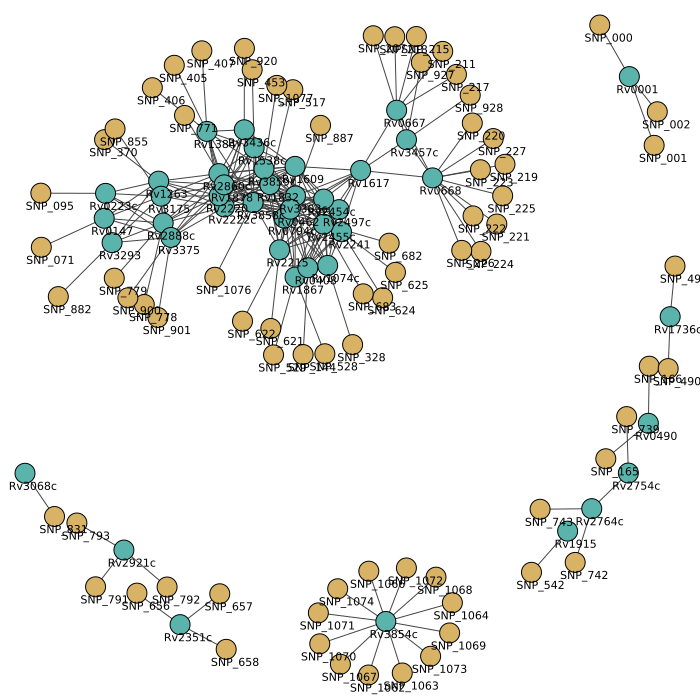

In [44]:
# Draw subgraph
layout = subgraph.layout("kk")
color_dict = {"snp": "#d8b365", "gene": "#5ab4ac"}

visual_style = {}
visual_style["vertex_size"] = 20
visual_style["vertex_color"] = [color_dict[vs_type] for vs_type in subgraph.vs['type']]
visual_style["vertex_label"] = subgraph.vs["name"]
visual_style["layout"] = layout
visual_style["bbox"] = (700, 700)
visual_style["margin"] = 25
visual_style["vertex_label_dist"] = 1
visual_style["vertex_label_size"] = 11
visual_style["vertex_label_angle"] = -1
visual_style["isolated"] = True
# Save to file
igraph.plot(subgraph, './examples/figures/georgia/genes_ranked_cov60_MDRplus_trClusters_net.pdf', **visual_style)

### 8.2 For DR groups

**MDR group**

In [45]:
from IPython.core.display import display, SVG
# Top ranked genes in significant pathways covering 60% of the pathway raw score
significant_pathways_mdr = pathways_scores_MDR_Kn.significant_pathways(threshold=0.05)
genes_names_to_extract_mdr = list()
for pathway in significant_pathways_mdr:
    genes_scores = pathways_scores_MDR_Kn.genes_in_pathway(pathway_name=pathway, coverage=60)
    genes_names = [gene for score, gene in genes_scores]
    genes_names_to_extract_mdr.extend(genes_names)
genes_names_to_extract_mdr = list(set(genes_names_to_extract_mdr))

print(genes_names_to_extract_mdr)

# Extract SNPs present in these genes
snps_in_genes_mdr = list()
for gene in genes_names_to_extract_mdr:
    if gene in snps_by_genes_nodr_table.columns:
        snps_in_gene_bool = snps_by_genes_nodr_table.loc[:,gene]==1
        snps_in_genes_mdr.extend(snps_by_genes_nodr_table.index[snps_in_gene_bool])

snps_in_genes_mdr = list(set(snps_in_genes_mdr))
# Keep only SNPs found in MDR samples
# check if any of the SNPs are not found in any sample in MDR group
print(sum(snps_samples_table.loc[snps_in_genes_mdr,samples_MDR].sum(axis=1) == 0))
snps_in_samples_MDR = snps_samples_table.loc[snps_in_genes_mdr,samples_MDR].index[~(snps_samples_table.loc[snps_in_genes_mdr,samples_MDR].sum(axis=1) == 0)].tolist()

# Extract subgraph
subgraph_vs_names = list()
subgraph_vs_names.extend(genes_names_to_extract_mdr)
subgraph_vs_names.extend(snps_in_samples_MDR)

subgraph_vs_ids_mdr = (my_global_graph.vs(name_eq=vs_name)[0].index for vs_name in subgraph_vs_names)
subgraph_mdr = my_global_graph.subgraph(subgraph_vs_ids_mdr, implementation='create_from_scratch')

# Save to file
# Draw subgraph
layout_mdr = subgraph_mdr.layout("kk")
color_dict = {"snp": "#d8b365", "gene": "#5ab4ac"}

visual_style_mdr = {}
visual_style_mdr["layout"] = layout_mdr
visual_style_mdr["vertex_color"] = [color_dict[vs_type] for vs_type in subgraph_mdr.vs['type']]
visual_style_mdr["vertex_label"] = subgraph_mdr.vs["name"]
visual_style_mdr["vertex_size"] = 20
visual_style_mdr["bbox"] = (700, 700)
visual_style_mdr["margin"] = 35
visual_style_mdr["vertex_label_dist"] = 1
visual_style_mdr["vertex_label_size"] = 11
visual_style_mdr["vertex_label_angle"] = -1
visual_style_mdr["isolated"] = True

subgraph_mdr_file = './examples/figures/georgia/genes_ranked_cov60_MDR_net.pdf'
igraph.plot(subgraph_mdr, subgraph_mdr_file, **visual_style_mdr)

# Warning: the network bellow doesn't show correct labels in the notebook but 
# in the saved pdf file nodes are properly labeled
# This is an issue not yet solved by igraph

['Rv2222c', 'Rv2220', 'Rv3175', 'Rv0982', 'Rv2921c', 'Rv2241', 'Rv3859c', 'Rv1263', 'Rv0843', 'Rv3068c', 'Rv2139', 'Rv2351c', 'Rv0490', 'Rv1617', 'Rv1867', 'Rv2215', 'Rv0462', 'Rv3436c', 'Rv1074c', 'Rv1736c', 'Rv2201', 'Rv1832', 'Rv0668', 'Rv3375', 'Rv0408', 'Rv2455c', 'Rv1384', 'Rv3858c', 'Rv3303c', 'Rv3457c', 'Rv0223c', 'Rv3214', 'Rv0070c', 'Rv2764c', 'Rv0794c', 'Rv1547', 'Rv1878', 'Rv0667', 'Rv0147', 'Rv1915', 'Rv3293', 'Rv2454c', 'Rv2860c', 'Rv2888c']
12


**PreXDR (INJ)**

['Rv2222c', 'Rv2220', 'Rv3175', 'Rv0982', 'Rv2476c', 'Rv2921c', 'Rv2241', 'Rv3854c', 'Rv3859c', 'Rv1263', 'Rv3068c', 'Rv2754c', 'Rv2351c', 'Rv0490', 'Rv1617', 'Rv1867', 'Rv2215', 'Rv0462', 'Rv3436c', 'Rv1538c', 'Rv1074c', 'Rv0946c', 'Rv1736c', 'Rv1832', 'Rv0668', 'Rv3375', 'Rv0408', 'Rv2455c', 'Rv1384', 'Rv3858c', 'Rv3303c', 'Rv1609', 'Rv3457c', 'Rv0223c', 'Rv2497c', 'Rv0794c', 'Rv0667', 'Rv1878', 'Rv0147', 'Rv1915', 'Rv3293', 'Rv2454c', 'Rv2860c', 'Rv2888c']
10


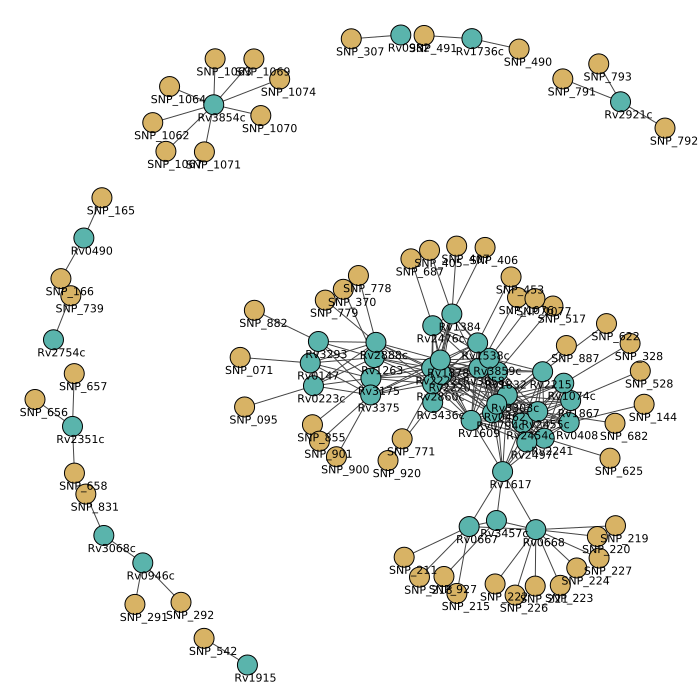

In [46]:
# Top ranked genes in significant pathways covering 60% of the pathway raw score
significant_pathways_PreXDR_INJ = pathways_scores_PreXDR_INJ_Kn.significant_pathways(threshold=0.05)
genes_names_to_extract_PreXDR_INJ = list()
for pathway in significant_pathways_PreXDR_INJ:
    genes_scores = pathways_scores_PreXDR_INJ_Kn.genes_in_pathway(pathway_name=pathway, coverage=60)
    genes_names = [gene for score, gene in genes_scores]
    genes_names_to_extract_PreXDR_INJ.extend(genes_names)
genes_names_to_extract_PreXDR_INJ = list(set(genes_names_to_extract_PreXDR_INJ))

print(genes_names_to_extract_PreXDR_INJ)

# Extract SNPs present in these genes
snps_in_genes_PreXDR_INJ = list()
for gene in genes_names_to_extract_PreXDR_INJ:
    if gene in snps_by_genes_nodr_table.columns:
        snps_in_gene_bool = snps_by_genes_nodr_table.loc[:,gene]==1
        snps_in_genes_PreXDR_INJ.extend(snps_by_genes_nodr_table.index[snps_in_gene_bool])
snps_in_genes_PreXDR_INJ = list(set(snps_in_genes_PreXDR_INJ))

# Keep only SNPs found in PreXDR_INJ samples
# check if any of the SNPs are not found in any sample in PreXDR_INJ group
print(sum(snps_samples_table.loc[snps_in_genes_mdr,samples_PreXDR_INJ].sum(axis=1) == 0))
snps_in_samples_PreXDR_INJ= snps_samples_table.loc[snps_in_genes_PreXDR_INJ,samples_PreXDR_INJ].index[~(snps_samples_table.loc[snps_in_genes_PreXDR_INJ,samples_PreXDR_INJ].sum(axis=1) == 0)].tolist()

# Extract subgraph
subgraph_vs_names = list()
subgraph_vs_names.extend(genes_names_to_extract_PreXDR_INJ)
subgraph_vs_names.extend(snps_in_samples_PreXDR_INJ)

subgraph_vs_ids = (my_global_graph.vs(name_eq=vs_name)[0].index for vs_name in subgraph_vs_names)
subgraph_PreXDR_INJ = my_global_graph.subgraph(subgraph_vs_ids, implementation='create_from_scratch')

# Save to file
layout_preXDR_INJ = subgraph_PreXDR_INJ.layout("kk")
visual_style_preXDR_INJ = {}
visual_style_preXDR_INJ["layout"] = layout_preXDR_INJ
visual_style_preXDR_INJ["vertex_color"] = [color_dict[vs_type] for vs_type in subgraph_PreXDR_INJ.vs['type']]
visual_style_preXDR_INJ["vertex_label"] = subgraph_PreXDR_INJ.vs["name"]
visual_style_preXDR_INJ["vertex_size"] = 20
visual_style_preXDR_INJ["bbox"] = (700, 700)
visual_style_preXDR_INJ["margin"] = 35
visual_style_preXDR_INJ["vertex_label_dist"] = 1
visual_style_preXDR_INJ["vertex_label_size"] = 11
visual_style_preXDR_INJ["vertex_label_angle"] = -1
visual_style_preXDR_INJ["isolated"] = True

igraph.plot(subgraph_PreXDR_INJ, './examples/figures/georgia/genes_ranked_cov60_PreXDR_INJ_net.pdf', **visual_style_preXDR_INJ)

**PreXDR (FQ)**

In [47]:
# Top ranked genes in significant pathways covering 60% of the pathway raw score
significant_pathways_PreXDR_FQ = pathways_scores_PreXDR_FLQ_Kn.significant_pathways(threshold=0.05)
genes_names_to_extract_PreXDR_FQ = list()
for pathway in significant_pathways_PreXDR_FQ:
    genes_scores = pathways_scores_PreXDR_FLQ_Kn.genes_in_pathway(pathway_name=pathway, coverage=60)
    genes_names = [gene for score, gene in genes_scores]
    genes_names_to_extract_PreXDR_FQ.extend(genes_names)
genes_names_to_extract_PreXDR_FQ = list(set(genes_names_to_extract_PreXDR_INJ))

print(genes_names_to_extract_PreXDR_FQ)

# Extract SNPs present in these genes
snps_in_genes_PreXDR_FQ = list()
for gene in genes_names_to_extract_PreXDR_FQ:
    if gene in snps_by_genes_nodr_table.columns:
        snps_in_gene_bool = snps_by_genes_nodr_table.loc[:,gene]==1
        snps_in_genes_PreXDR_FQ.extend(snps_by_genes_nodr_table.index[snps_in_gene_bool])
snps_in_genes_PreXDR_FQ = list(set(snps_in_genes_PreXDR_FQ))

# Keep only SNPs found in PreXDR_FQ samples
# check if any of the SNPs are not found in any sample PreXDR_FQ group
print(sum(snps_samples_table.loc[snps_in_genes_PreXDR_FQ,samples_PreXDR_FLQ].sum(axis=1) == 0))
snps_in_samples_PreXDR_FQ= snps_samples_table.loc[snps_in_genes_PreXDR_FQ,samples_PreXDR_FLQ].index[~(snps_samples_table.loc[snps_in_genes_PreXDR_FQ,samples_PreXDR_FLQ].sum(axis=1) == 0)].tolist()

# Extract subgraph
subgraph_vs_names = list()
subgraph_vs_names.extend(genes_names_to_extract_PreXDR_FQ)
subgraph_vs_names.extend(snps_in_samples_PreXDR_FQ)

subgraph_vs_ids = (my_global_graph.vs(name_eq=vs_name)[0].index for vs_name in subgraph_vs_names)
subgraph_PreXDR_FQ = my_global_graph.subgraph(subgraph_vs_ids, implementation='create_from_scratch')

# Save to file
layout_preXDR_FQ = subgraph_PreXDR_FQ.layout("kk")
visual_style_preXDR_FQ = {}
visual_style_preXDR_FQ["layout"] = layout_preXDR_FQ
visual_style_preXDR_FQ["vertex_color"] = [color_dict[vs_type] for vs_type in subgraph_PreXDR_FQ.vs['type']]
visual_style_preXDR_FQ["vertex_label"] = subgraph_PreXDR_FQ.vs["name"]
visual_style_preXDR_FQ["vertex_size"] = 20
visual_style_preXDR_FQ["bbox"] = (700, 700)
visual_style_preXDR_FQ["margin"] = 35
visual_style_preXDR_FQ["vertex_label_dist"] = 1
visual_style_preXDR_FQ["vertex_label_size"] = 11
visual_style_preXDR_FQ["vertex_label_angle"] = -1
visual_style_preXDR_FQ["isolated"] = True

igraph.plot(subgraph_PreXDR_FQ, './examples/figures/georgia/genes_ranked_cov60_PreXDR_FQ_net.pdf', **visual_style_preXDR_FQ)

['Rv2222c', 'Rv2220', 'Rv2476c', 'Rv0982', 'Rv3175', 'Rv2921c', 'Rv2241', 'Rv3854c', 'Rv3859c', 'Rv1263', 'Rv3068c', 'Rv2754c', 'Rv2351c', 'Rv0490', 'Rv1617', 'Rv2215', 'Rv1867', 'Rv0462', 'Rv3436c', 'Rv1538c', 'Rv1074c', 'Rv0946c', 'Rv1736c', 'Rv1832', 'Rv0668', 'Rv3375', 'Rv0408', 'Rv2455c', 'Rv1384', 'Rv3858c', 'Rv3303c', 'Rv1609', 'Rv3457c', 'Rv0223c', 'Rv2497c', 'Rv0794c', 'Rv0667', 'Rv1878', 'Rv0147', 'Rv1915', 'Rv3293', 'Rv2454c', 'Rv2860c', 'Rv2888c']
42


**XDR samples**

In [48]:
# Top ranked genes in significant pathways covering 60% of the pathway raw score
significant_pathways_XDR = pathways_scores_XDR_Kn.significant_pathways(threshold=0.05)
genes_names_to_extract_XDR = list()
for pathway in significant_pathways_XDR:
    genes_scores = pathways_scores_XDR_Kn.genes_in_pathway(pathway_name=pathway, coverage=60)
    genes_names = [gene for score, gene in genes_scores]
    genes_names_to_extract_XDR.extend(genes_names)
genes_names_to_extract_XDR = list(set(genes_names_to_extract_XDR))

print(genes_names_to_extract_XDR)

# Extract SNPs present in these genes
snps_in_genes_XDR = list()
for gene in genes_names_to_extract_XDR:
    if gene in snps_by_genes_nodr_table.columns:
        snps_in_gene_bool = snps_by_genes_nodr_table.loc[:,gene]==1
        snps_in_genes_XDR.extend(snps_by_genes_nodr_table.index[snps_in_gene_bool])
snps_in_genes_XDR = list(set(snps_in_genes_XDR))

# Keep only SNPs found in XDR samples
# check if any of the SNPs are not found in any sample in XDR samples
print(sum(snps_samples_table.loc[snps_in_genes_XDR,samples_XDR].sum(axis=1) == 0))
snps_in_samples_XDR= snps_samples_table.loc[snps_in_genes_XDR,samples_XDR].index[~(snps_samples_table.loc[snps_in_genes_XDR,samples_XDR].sum(axis=1) == 0)].tolist()

# Extract subgraph
subgraph_vs_names = list()
subgraph_vs_names.extend(genes_names_to_extract_XDR)
subgraph_vs_names.extend(snps_in_samples_XDR)

subgraph_vs_ids = (my_global_graph.vs(name_eq=vs_name)[0].index for vs_name in subgraph_vs_names)
subgraph_XDR = my_global_graph.subgraph(subgraph_vs_ids, implementation='create_from_scratch')

# Save to file
layout_XDR = subgraph_XDR.layout("kk")
visual_style_XDR = {}
visual_style_XDR["layout"] = layout_XDR
visual_style_XDR["vertex_color"] = [color_dict[vs_type] for vs_type in subgraph_XDR.vs['type']]
visual_style_XDR["vertex_label"] = subgraph_XDR.vs["name"]
visual_style_XDR["vertex_size"] = 20
visual_style_XDR["bbox"] = (700, 700)
visual_style_XDR["margin"] = 35
visual_style_XDR["vertex_label_dist"] = 1
visual_style_XDR["vertex_label_size"] = 11
visual_style_XDR["vertex_label_angle"] = -1
visual_style_XDR["isolated"] = True

igraph.plot(subgraph_XDR, './examples/figures/georgia/genes_ranked_cov60_XDR_net.pdf', **visual_style_XDR)

['Rv2220', 'Rv2222c', 'Rv2476c', 'Rv3175', 'Rv2349c', 'Rv0001', 'Rv2241', 'Rv0983', 'Rv2702', 'Rv3854c', 'Rv2921c', 'Rv3859c', 'Rv3339c', 'Rv3068c', 'Rv2754c', 'Rv2351c', 'Rv0490', 'Rv1617', 'Rv1867', 'Rv2215', 'Rv0462', 'Rv3436c', 'Rv1699', 'Rv1074c', 'Rv1832', 'Rv0668', 'Rv3375', 'Rv0408', 'Rv2455c', 'Rv1384', 'Rv3858c', 'Rv3303c', 'Rv3457c', 'Rv1609', 'Rv0223c', 'Rv2497c', 'Rv0794c', 'Rv0667', 'Rv1878', 'Rv0337c', 'Rv0147', 'Rv1915', 'Rv3293', 'Rv2454c', 'Rv2860c', 'Rv2888c']
27


## 9. SNPs counts in genes from top ranked pathways

### 9.1 Among samples in transmission clusters

In [49]:
# All genes in significant pathways, covering 100% of the pathway raw score
significant_pathways = pathways_scores_inTrclus_Kn.significant_pathways(threshold=0.05)

pathways_snps_counts = dict()
genes_in_sig_pathways = list()
snps_in_sig_pathways = list()
for pathway in significant_pathways:
    genes_scores = pathways_scores_inTrclus_Kn.genes_in_pathway(pathway_name=pathway, coverage=100)
    genes_names = [gene for score, gene in genes_scores]
    genes_loc_bool = pd.Series(snps_by_genes_nodr_table.columns.values).isin(genes_names).tolist()
    genes_in_sig_pathways.extend(snps_by_genes_nodr_table.loc[:,genes_loc_bool].columns.values)
    snps_in_genes = snps_by_genes_nodr_table.loc[:,genes_loc_bool]
    snps_in_genes = snps_in_genes.loc[snps_in_genes.sum(axis=1)>0,:]
    snps_in_sig_pathways.extend(snps_in_genes.index.values)
    snps_counts = snps_in_genes.sum().sum()
    pathways_snps_counts[pathway_names[pathway]] = snps_counts

genes_in_sig_pathways = list(set(genes_in_sig_pathways))
snps_in_sig_pathways = list(set(snps_in_sig_pathways))
pathways_snps_counts

{'Alanine, aspartate and glutamate metabolism': 10,
 'Aminobenzoate degradation': 22,
 'Arginine and proline metabolism': 16,
 'Citrate cycle (TCA cycle)': 10,
 'Ether lipid metabolism': 6,
 'Glycolysis / Gluconeogenesis': 21,
 'Glyoxylate and dicarboxylate metabolism': 10,
 'Nitrogen metabolism': 6,
 'Protein export': 3,
 'Pyrimidine metabolism': 33,
 'Pyruvate metabolism': 14,
 'Quorum sensing': 10,
 'RNA polymerase': 17,
 'Styrene degradation': 7,
 'Two-component system': 16}

In [50]:
snps_by_genes_nodr_table.loc[:,['Rv0668','Rv0667','Rv3457c']].sum()

Rv0668     9
Rv0667     5
Rv3457c    2
dtype: int64

In [51]:
# Save table of SNPs and genes in pathways with significant importance scores 
# for MDR+ samples in transmission clusters
snps_by_genes_nodr_significant_pathways_MDRplus_trClusters = snps_by_genes_nodr_table.loc[snps_in_sig_pathways,genes_in_sig_pathways]
snps_by_genes_nodr_significant_pathways_MDRplus_trClusters.to_csv('./examples/data/georgia/SNPs_to_genes_sigPathways_MDRplus_trClusters.txt', 
                                                                  sep='\t',header=True, index=True)